# SIS Model with no demographics

Moving on from the SI model to something with slightly more complex dynamics, we will add a state transition from infected back to susceptible, with no period of immunity - this is the SIS model.  It turns out that the equations governing this will be analogous to the SI model with demography - rather than births & mortality providing routes to add susceptibles and subtract infectives, this transition from infective -> susceptible will provide essentially the same mechanism. 

$$
\dot{S} = -\frac{\beta*S*I}{N} + \gamma I\\

\dot{I} = \frac{\beta*S*I}{N} - \gamma I
$$

As before, subbing $S = N-I$ into the second equation gives us

$$ \dot{I} = \beta I ( 1-\frac{\gamma}{\beta}-\frac{I}{N})$$

And comparing against the SI model with births, it is clear this equation is of the same form, with solution
$$
\frac{Nx}{1+(\frac{Nx}{I_0}-1)e^{-\beta x t}} \\
x = (1-\frac{\gamma}{\beta})
$$


This notebook tests the implementation and behavior of the model as follows:
### Contruct the model
In the first few cells, we do all the necessary imports.  Then we construct a single-patch LASER model with three components: `Susceptible`, `Infectious`, and `Transmission` - this component will require a new agent property `itimer`, set according to a user-specific distribution `model.infectious_duration_fn`.  Upon expiration of `itimer`, agents will return to the susceptible state.  Finally, we initialize with a single infection and run. 


### Sanity check
The first test ensures certain basic constraints are being obeyed by the model.  We confirm that at each timestep, $S_t=N_t-I_t$. 

### Scientific test
Finally, we come to the scientific test.  As before, we first test on a single instance of the model and show that the expected output is recovered.  Then, we select a few values of $\beta$ and $\gamma$, run the model, fit the outputs to the logistic equation, and compare the fitted value of $\beta$ and $\gamma$ to the known values; all of the considerations noted in the SI with births model, in terms of how to approach this fit, are echoed again here.  Of particular concern is the exponentially distributed transition from infected back to susceptible, as we are doing a first-order finite timestep integration, we will incur discretization error linear in $\gamma \Delta t$.  A lot of real diseases have exposed or infectious periods that are on average only a few days long, so using 1-day timesteps would incur some errors.  Those real-world dwell times are also not usually exponentially distributed, and that discretization bias will be different for different choices of distribution.  It's up to user discretion, when doing real epi modeling and fitting model parameters and behavior to noisy, real-world data, whether any biases induced by discretizing dwell times are a major source of concern; it is raised here because we are trying to recover model parameters by comparing outputs specifically against an analytic result. 


In [1]:
import matplotlib.pyplot as plt
import numba as nb
import numpy as np
import pandas as pd
from laser_core.propertyset import PropertySet
from scipy.optimize import curve_fit
from scipy.optimize import minimize

import laser_core

print(f"{np.__version__=}")
print(f"{laser_core.__version__=}")


np.__version__='2.3.3'
laser_core.__version__='0.6.0'


In [2]:
from functools import partial

from laser_core.demographics import AliasedDistribution
from laser_core.demographics import KaplanMeierEstimator
import laser_generic.models.SIS as SIS
from laser_generic.newutils import RateMap
from laser_generic.newutils import draw_vital_dynamics
from laser_generic.newutils import grid

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


To make sure we don't accumulate lots of finite time-step error, make inf mean quite long in units of timestep

In [3]:
pop = 1e5

scenario = grid(M=1, N=1, node_size_km=10, population_fn=lambda x,y: pop, origin_x=0, origin_y=0)
initial_infected = 3
scenario["S"] = scenario.population - initial_infected
scenario["I"] = initial_infected
parameters = PropertySet({"seed": 42, "nticks": 3000, "beta": 0.1, "inf_mean": 24})
model = SIS.Model(scenario, parameters)

inf_mean = np.float32(parameters.inf_mean)
@nb.njit(nogil=True, cache=False)
def infectious_duration_distribution():
    draw = np.random.exponential(scale=inf_mean)
    rounded = np.floor(draw)
    asuint16 = np.uint16(rounded)
    clipped = np.maximum(1, asuint16)
    return clipped

model.infectious_duration_fn = infectious_duration_distribution
model.components = [SIS.Susceptible(model), SIS.Infectious(model),  SIS.Transmission(model)] # , SIS.VitalDynamics(model)]


In [4]:

model.run()

Running Simulation SIS Model: 100%|██████████| 3000/3000 [00:01<00:00, 1883.45it/s]


# Sanity checks
Check that the relationships between susceptible, infected, and total population hold.

S = N-I:  True


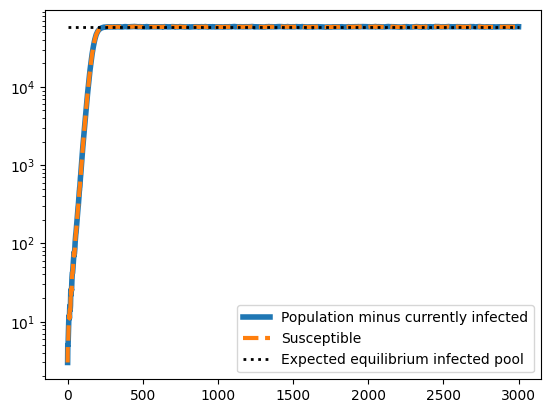

In [5]:
plt.plot(model.nodes.I, lw=4)
N = model.nodes.S + model.nodes.I
plt.plot(N - model.nodes.S.astype("int"), "--", lw=3)
plt.plot([0, model.params.nticks], [(1- 1 / model.params.beta * 1 / model.params.inf_mean) * N[0], (1-1 / model.params.beta * 1 / model.params.inf_mean) * N[0]], ":k", lw=2)
plt.yscale("log")
plt.legend(["Population minus currently infected", "Susceptible", "Expected equilibrium infected pool"])
print("S = N-I:  " + str(np.isclose(model.nodes.S, N - model.nodes.I).all()))


### Single-simulation check
As before, starting with a single infection induces some stochasticity in terms of when the outbreak really starts to take off, and so we fit the expected behavior with a free offset parameter below.

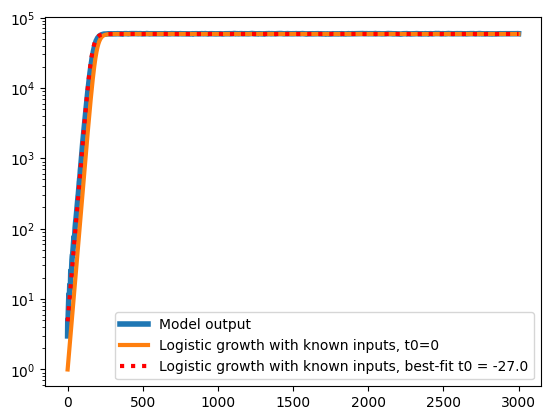

In [6]:
def SIS_logistic(t, beta, popsize, gamma, t0):
    x = 1 - gamma / beta
    return popsize * x / (1 + (popsize * x - 1) * np.exp(-beta * x * (t - t0)))


t = np.arange(model.params.nticks+1)


def objective(t0):
    return np.sum(
        (1 - SIS_logistic(t, model.params.beta, pop, 1 / model.params.inf_mean, t0) / np.squeeze(model.nodes.I)) ** 2
    )


result = minimize(objective, x0=10)
t0_opt = result.x[0]

plt.plot(model.nodes.I, lw=4)
plt.plot(SIS_logistic(t, model.params.beta, pop, 1 / model.params.inf_mean, 0), lw=3)
plt.plot(SIS_logistic(t, model.params.beta, pop, 1 / model.params.inf_mean, t0_opt), "r:", lw=3)
plt.yscale("log")
plt.legend(["Model output", "Logistic growth with known inputs, t0=0", f"Logistic growth with known inputs, best-fit t0 = {t0_opt:.1f}"])

## Scientific testing
Finally, we run the model for a range of $\beta$ & $\gamma$  parameters, we freely fit the model output to the logistic equation, and we compare the known input parameters against the parameters fitted from output.  

We will use only relatively large values of $\gamma$ for this procedure.  The reason why will become clear in a second test, where we demonstrate that there is an error between the expected final size and the modeled final size, and that this error shrinks with $\gamma \Delta t$, as we would expect a first-order approximation error to.  

To make this a pass-fail test, we will raise a flag if the fitted parameters are more than 5% different than the known ones.

In [11]:
# %%capture

NTESTS = 10
nticks = 1000
t = np.arange(nticks)
R0range = [2.5, 5]
gammarange = [1 / 300, 1 / 50]
seeds = list(range(NTESTS))
pop = 1e5
R0s = np.random.uniform(R0range[0], R0range[1], NTESTS)
gammas = np.random.uniform(gammarange[0], gammarange[1], NTESTS)
betas = R0s * gammas
output = pd.DataFrame(columns=["seed", "beta", "gamma", "cases", "fitted_beta", "fitted_gamma", "fitted_t0"])
# scenario = pd.DataFrame(data=[["homenode", pop]], columns=["name", "population"])
scenario = grid(M=1, N=1, node_size_km=10, population_fn=lambda x,y: pop, origin_x=0, origin_y=0)
initial_infected = 3
scenario["S"] = scenario.population - initial_infected
scenario["I"] = initial_infected

for i, (seed, beta, gamma) in enumerate(zip(seeds, betas, gammas)):
    parameters = PropertySet({"seed": seed, "nticks": nticks, "verbose": True, "beta": beta, "inf_mean": 1 / gamma})

    model = SIS.Model(scenario, parameters)

    inf_mean = np.float32(parameters.inf_mean)
    @nb.njit(nogil=True, cache=False)
    def infectious_duration_distribution():
        draw = np.random.exponential(scale=inf_mean)
        rounded = np.floor(draw)
        asuint16 = np.uint16(rounded)
        clipped = np.maximum(1, asuint16)
        return clipped

    model.infectious_duration_fn = infectious_duration_distribution


    model.components = [SIS.Susceptible(model), SIS.Infectious(model), SIS.Transmission(model)] # , SIS.VitalDynamics(model)]

    model.run(label=f"SIS {i} of {NTESTS}, seed={seed}, beta={beta:.3f}, gamma={gamma:.5f}")
    cases = model.nodes.I[1:,0]
    popt, pcov = curve_fit(
        SIS_logistic,
        t,
        cases,
        p0=[0.01, pop, np.mean(gammarange), 1],
        bounds=([0.0001, pop - 1, gammarange[0] / 2, -300], [0.5, pop + 1, gammarange[1] * 2, 300]),
    )

    output = pd.concat(
        [
            output,
            pd.DataFrame.from_dict(
                {
                    "seed": seed,
                    "beta": beta,
                    "gamma": gamma,
                    "cases": [np.array(cases)],
                    "fitted_beta": popt[0],
                    "fitted_gamma": popt[2],
                    "fitted_t0": popt[3],
                }
            ),
        ],
        ignore_index=True,
    )

Running Simulation SIS 0 of 10, seed=0, beta=0.027, gamma=0.00681: 100%|██████████| 1000/1000 [00:00<00:00, 2454.28it/s]
/var/folders/1b/yq6gx3hj51jf_v98kwv057xh0000gn/T/ipykernel_57830/3740515275.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output = pd.concat(
Running Simulation SIS 1 of 10, seed=1, beta=0.048, gamma=0.01069: 100%|██████████| 1000/1000 [00:00<00:00, 2436.25it/s]
Running Simulation SIS 2 of 10, seed=2, beta=0.059, gamma=0.01399: 100%|██████████| 1000/1000 [00:00<00:00, 2465.10it/s]
Running Simulation SIS 3 of 10, seed=3, beta=0.060, gamma=0.01458: 100%|██████████| 1000/1000 [00:00<00:00, 2468.26it/s]
Running Simulation SIS 4 of 10, seed=4, beta=0.069, gamma=0.01414: 100%|██████████| 1000/1000 [00:00<00:00, 2467.03it

Text(0.5, 1.0, 'Relative error in true and fitted $\\gamma$')

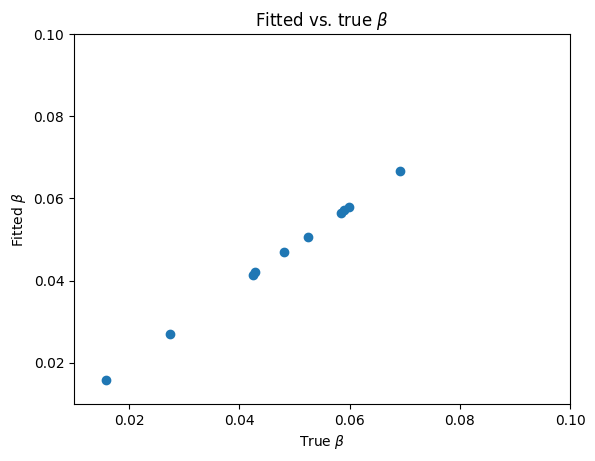

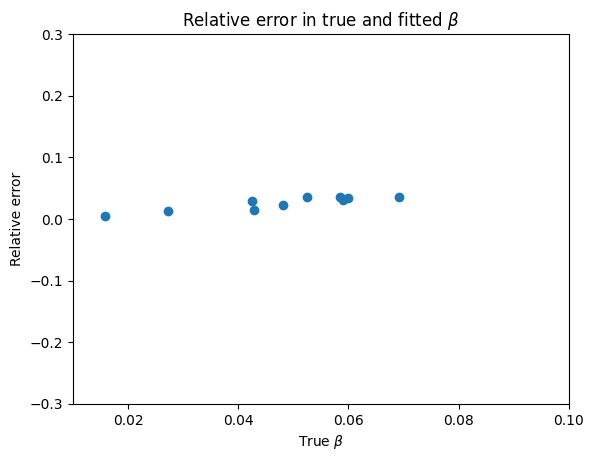

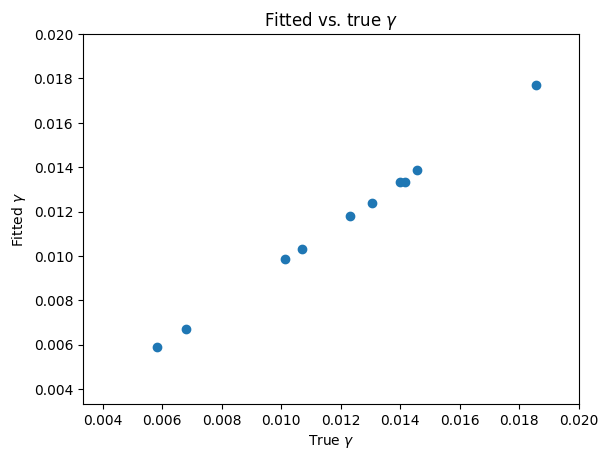

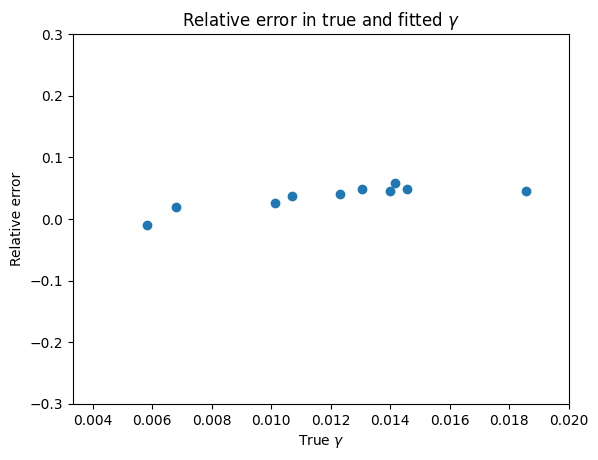

In [12]:
plt.figure()
plt.plot(output["beta"], output["fitted_beta"], "o")
plt.xlim(0.01, 0.1)
plt.ylim(0.01, 0.1)
plt.xlabel(r"True $\beta$")
plt.ylabel(r"Fitted $\beta$")
plt.title(r"Fitted vs. true $\beta$")
plt.figure()

plt.plot(output["beta"], (output["beta"] - output["fitted_beta"])/output["beta"], "o")
plt.xlim(0.01, 0.1)
plt.ylim(-.3, .3)
plt.xlabel(r"True $\beta$")
plt.ylabel(r"Relative error")
plt.title(r"Relative error in true and fitted $\beta$")

plt.figure()
plt.plot(output["gamma"], output["fitted_gamma"], "o")
plt.xlim(gammarange[0], gammarange[1])
plt.ylim(gammarange[0], gammarange[1])
plt.xlabel(r"True $\gamma$")
plt.ylabel(r"Fitted $\gamma$")
plt.title(r"Fitted vs. true $\gamma$")

plt.figure()
plt.plot(output["gamma"], (output["gamma"] - output["fitted_gamma"])/output["gamma"], "o")
plt.xlim(gammarange[0], gammarange[1])
plt.ylim(-.3, .3)
plt.xlabel(r"True $\gamma$")
plt.ylabel(r"Relative error")
plt.title(r"Relative error in true and fitted $\gamma$")

In [13]:
print(
    "All fitted beta are within 5% of known beta: " + str(np.all(np.abs((output["beta"] - output["fitted_beta"]) / output["beta"]) < 0.05))
)
print(
    "All fitted gamma are within 10% of known gamma: "
    + str(np.all(np.abs((output["gamma"] - output["fitted_gamma"]) / output["gamma"]) < 0.1))
)

All fitted beta are within 5% of known beta: True
All fitted gamma are within 10% of known gamma: True


In [14]:
output

,seed,beta,gamma,cases,fitted_beta,fitted_gamma,fitted_t0
0,0,0.027338,0.006811,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",0.026972,0.006684,-25.664409
1,1,0.048090,0.010693,"[3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 5, 5, 5, 5, 5, ...",0.046991,0.010298,-13.244501
2,2,0.058983,0.013986,"[4, 6, 7, 8, 8, 7, 8, 10, 10, 10, 10, 10, 12, ...",0.057188,0.013352,-31.081946
3,3,0.059936,0.014575,"[3, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",0.057936,0.013878,2.791622
4,4,0.069237,0.014144,"[3, 4, 5, 5, 6, 7, 7, 8, 8, 10, 11, 12, 13, 13...",0.066718,0.013326,-43.406579
5,5,0.042457,0.012317,"[3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, ...",0.041234,0.011812,-40.664660
6,6,0.058486,0.018544,"[3, 3, 3, 4, 3, 3, 4, 4, 4, 5, 5, 5, 5, 4, 4, ...",0.056432,0.017702,-5.034567
7,7,0.042790,0.010112,"[3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 6, 6, ...",0.042194,0.009855,-24.179789
8,8,0.052447,0.013047,"[5, 6, 6, 6, 6, 6, 6, 6, 6, 9, 9, 10, 9, 11, 1...",0.050557,0.012405,-17.145137
9,9,0.015773,0.005820,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, ...",0.015694,0.005881,-192.308465


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/kevinmccarthy/anaconda3/envs/env_laser/lib/python3.13/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
    ~~~~~~~~^^
  File "/Users/kevinmccarthy/anaconda3/envs/env_laser/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 663, in shell_channel_thread_main
    _, msg2 = self.session.feed_identities(msg, copy=False)
              ~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^
  File "/Users/kevinmccarthy/anaconda3/envs/env_laser/lib/python3.13/site-packages/jupyter_client/session.py", line 994, in feed_identities
    raise ValueError(msg)
ValueError: DELIM not in msg_list
ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/kevinmccarthy/anaconda3/envs/env_laser/lib/python3.13/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
    ~~~~~~~~^^
  Fi

### Quick demonstration of first-order error accumulation
As noted before, for $\gamma \Delta t$ large, first-order integration like we are doing here can accumulate substantial error.  Calculating exactly how error will accumulate in an integrator for a dynamic process like this is beyond the scope here, and probably depends on a lot of details.  E.g., the ordering of steps - in a given step, does the `transmission` update from S->I state occur before or after the `infection` update that sends agents from I->S?  Do we use midpoint methods, timer countdowns, or take advantage of the unique memorylessness of the exponential distribution to simply remove a random fraction each time?  All that is beyond scope here, but just want to demonstrate that the error in the equilibrium value $I(t \rightarrow \infty)$ becomes large when the mean infectious period $\frac{1}{\gamma}$ is on the same order as $\Delta t$

In [137]:
# %%capture

gammas = [1 / infmean for infmean in [1, 1.5, 2, 2.5, 3, 6, 12, 18, 30, 45, 60, 90, 120, 180, 240, 300]]
betas = [3 * gamma for gamma in gammas]

NTESTS = len(gammas)
nticks = 3000
seeds = list(range(NTESTS))
pop = 1e5
final_expected = np.array([])
final_observed = np.array([])
# scenario = pd.DataFrame(data=[["homenode", pop]], columns=["name", "population"])
scenario = grid(M=1, N=1, node_size_km=10, population_fn=lambda x,y: pop, origin_x=0, origin_y=0)
initial_infected = 20
scenario["S"] = scenario.population - initial_infected
scenario["I"] = initial_infected

for i, (seed, beta, gamma) in enumerate(zip(seeds, betas, gammas)):
    parameters = PropertySet({"seed": seed, "nticks": nticks, "verbose": True, "beta": beta, "inf_mean": 1 / gamma})
    model = SIS.Model(scenario, parameters)
    inf_mean = np.float32(parameters.inf_mean)

    @nb.njit(nogil=True, cache=False)
    def infectious_duration_distribution():
        draw = np.random.exponential(scale=inf_mean)
        rounded = np.ceil(draw)
        asuint16 = np.uint16(rounded)
        clipped = np.maximum(1, asuint16)
        return clipped

    model.infectious_duration_fn = infectious_duration_distribution

    model.components = [SIS.Susceptible(model), SIS.Infectious(model), SIS.Transmission(model)] # , SIS.VitalDynamics(model)]

    model.run(label=f"SIS {i+1} of {NTESTS}, seed={seed}, beta={beta:.3f}, gamma={gamma:.5f}")
    final_observed = np.append(final_observed, model.nodes.I[-1,0])
    final_expected = np.append(final_expected, pop * (1 - gamma / beta))

Running Simulation SIS 1 of 16, seed=0, beta=3.000, gamma=1.00000: 100%|██████████| 3000/3000 [00:05<00:00, 549.21it/s]
Running Simulation SIS 2 of 16, seed=1, beta=2.000, gamma=0.66667: 100%|██████████| 3000/3000 [00:04<00:00, 668.64it/s]
Running Simulation SIS 3 of 16, seed=2, beta=1.500, gamma=0.50000: 100%|██████████| 3000/3000 [00:03<00:00, 847.12it/s]
Running Simulation SIS 4 of 16, seed=3, beta=1.200, gamma=0.40000: 100%|██████████| 3000/3000 [00:03<00:00, 900.33it/s]
Running Simulation SIS 5 of 16, seed=4, beta=1.000, gamma=0.33333: 100%|██████████| 3000/3000 [00:02<00:00, 1010.11it/s]
Running Simulation SIS 6 of 16, seed=5, beta=0.500, gamma=0.16667: 100%|██████████| 3000/3000 [00:02<00:00, 1471.96it/s]
Running Simulation SIS 7 of 16, seed=6, beta=0.250, gamma=0.08333: 100%|██████████| 3000/3000 [00:01<00:00, 1843.08it/s]
Running Simulation SIS 8 of 16, seed=7, beta=0.167, gamma=0.05556: 100%|██████████| 3000/3000 [00:01<00:00, 2084.27it/s]
Running Simulation SIS 9 of 16, seed

Text(0.5, 1.0, 'Error in equilibrium infected fraction increases roughly with increasing $\\gamma \\Delta t$')

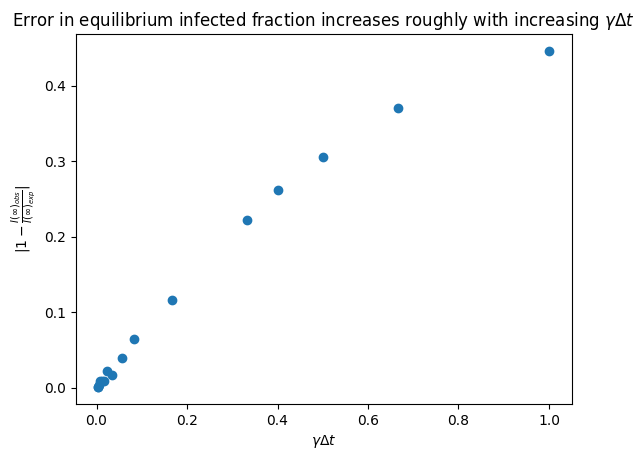

In [143]:
plt.plot(gammas, np.abs(1 - final_observed / final_expected), "o")
plt.xlabel(r"$\gamma \Delta t$")
plt.ylabel("$| 1 - \\frac{I(\\infty)_{obs}}{I(\\infty)_{exp}} |$")
plt.title(r"Error in equilibrium infected fraction increases roughly with increasing $\gamma \Delta t$")